In [1]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");

v3.0


In [2]:
# Load initial wave
param = get_dense_param(40, 0.05)
    T = 10000.0
    @pack! param = T
    loaded, f, t = quiet_load_last_pde(param)
#

# centre f so ρ[end] ≈ ϕ
    @unpack Nx, ϕa, ϕp = param
    ϕ = ϕa + ϕp
    i = argmin(sum(f;dims=2)[:,1]);
    f = circshift(f,(-i,0));
    i = argmin(  abs.(sum(f;dims=2)[:,1].-ϕ)  )
    f = circshift(f,(-i,0));
#

param["Δx"], param["Nx"]

(0.05, 800)

In [39]:
# get neccessary paramters
@unpack DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp = param
ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp
ϕ = ϕa + ϕp

# flatten initial guess
ρ = sum(f;dims = 2)
ρa = f[:,2] + f[:,1]
m = f[:,2] - f[:,1]

normf, c1, dc = f_dot(param, f)
c = c1
C = [c]

u0 = vcat(ρ,ρa,m,C)[:,1]


get_u (generic function with 1 method)

In [40]:
ff(F,u0,ps);
#
maximum(abs.(F)), u0[end]
    # k = 5
    # j = 1
    # offset = 20
    # F[(j*(Nx-1)+Nx÷2-k-offset):(j*(Nx-1)+Nx÷2+k-offset)]
    # # argmax(abs.(F)), j*(Nx-1)+Nx÷2 -offset

(0.012249917056277627, 0.07294185441207994)

In [48]:
using ForwardDiff
fd = ForwardDiff.jacobian(return_f, u0);
jj(J,u0,ps)
err = fd -J
maximum(abs.(err))

4.440892098500626e-16

In [85]:
un = copy(u0);

In [86]:
# un = copy(u0)
fd = ForwardDiff.jacobian(return_f, un);
un -= fd/un
ff(F,un,ps);
maximum(abs.(F))

8429.261918722601

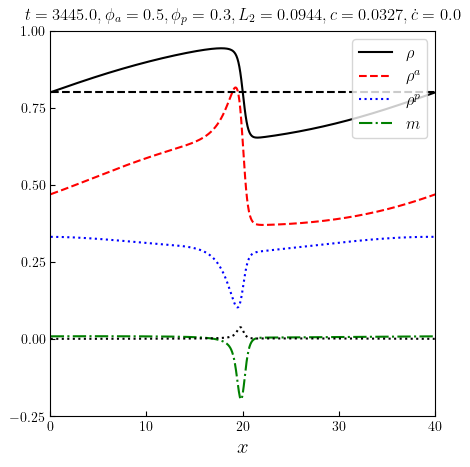

In [6]:
# Dispaly Profile
using PyPlot
PyPlot.close("all")
        rc("text", usetex=true)
        fig, ax = subplots(1,1,figsize=(5,5))
        @unpack Δx, Lx = param
        ax.plot(Δx:Δx:Lx, f[:,2]+f[:,1]+f[:,3]; 
        color = "black", linestyle = "-", label = L"\rho")
        ax.plot(Δx:Δx:Lx, f[:,1]+f[:,2]; 
        color = "red", linestyle = "--", label = L"\rho^a")
        ax.plot(Δx:Δx:Lx, f[:,3]; 
        color = "blue", linestyle = ":",label = L"\rho^p")
        ax.plot(Δx:Δx:Lx, f[:,2]-f[:,1]; 
        color = "green", linestyle = "-.", label = L"m")
        ax.plot(Δx:Δx:Lx, ϕ*ones(Nx); 
        color = "black", linestyle = "--", label = "_m")
        ax.plot(Δx:Δx:(Lx-Δx), abs.(F[1:(Nx-1)])+abs.(F[(Nx):1:(2*Nx-2)])+abs.(F[(2*Nx-1):(3*Nx-3)]);
        color = "black", linestyle = ":", label = "_m")

        d2(x) = round(x; digits = 2)
        d4(x) = round(x; digits = 4)
        d6(x) = round(x; digits = 6)
        normf, c1, dc = f_dot(param, f)
        latex_string = latexstring("\$ t = $(d2(t)), \\phi_a = $(param["ϕa"]), \\phi_p = $(param["ϕp"]), L_2 = $(d4(normf)), c = $(d4(c1)), {\\dot c} = $(d6(dc))\$")
        ax.set_title(latex_string, fontsize = 12)
        ax.get_xaxis().set_ticks(0:10.0:Lx)
        ax.get_yaxis().set_ticks(-0.25:0.25:1.0)
        # ax.set_xlabel(L"x", fontsize = 15)
        #ax.set_ylabel(L"m",fontsize = font, rotation = 90)
        ax.set_aspect((Lx/(1.25)))
        ax.axis([0,Lx,-0.25,1.0])
        ax.tick_params(direction = "in")
        ax.legend(loc= "upper right", fontsize = 12)
        ax.set_xlabel(L"x", fontsize = 15)
display(fig)

In [18]:
using Symbolics
F0 = copy(u0)
jac_sparsity = Symbolics.jacobian_sparsity((F, u) -> ff(F, u, ps), F0, u0)

2401×2401 SparseArrays.SparseMatrixCSC{Bool, Int64} with 350738 stored entries:
⡿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸
⡇⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⢸
⡇⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⢸
⡇⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⢸
⡇⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⢸
⡇⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⢸
⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣧⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢾
⡏⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸
⡇⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⢸
⡇⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⢸
⡇⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⢸
⡇⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⢸
⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⣸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⣸
⡷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⡷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢹⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢹
⡇⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⢸
⡇⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣦⡀⠀⠀⠀⠀⠀⠀⢸
⡇⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣦⡀⠀⠀⠀⠀⢸
⡇⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣦⡀⠀⠀⢸
⡇⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡀⢸
⣇⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣈⣳⣇⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣈⣳⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣾

In [89]:
ff_sparse = NonlinearFunction(ff; sparsity = jac_sparsity)

prob_sparse = NonlinearProblem(ff_sparse,u0, ps; abstol = 1e-12, reltol =  1e-12);
prob = NonlinearProblem(ff,u0, ps; abstol = 1e-12, reltol =  1e-12);

using BenchmarkTools # for @btime
@btime solve(prob);
@btime solve(prob, NewtonRaphson());
@btime solve(prob_sparse);
@btime solve(prob_sparse, NewtonRaphson());
# @btime solve(prob_sparse,NewtonRaphson(linsolve = KLUFactorization()));

  5.320 s (4586232 allocations: 6.67 GiB)
  5.349 s (4586200 allocations: 6.67 GiB)
  8.788 s (1636046 allocations: 2.49 GiB)
  8.948 s (1636014 allocations: 2.49 GiB)


u: 2401-element Vector{Float64}:
 0.8005298809701492
 0.8010598058165816
 0.8015897614171608
 0.8021197346442254
 0.8026497123363799
 0.803179681332292
 0.8037096284405852
 0.804239540474973
 0.8047694042236586
 0.8052992064842859
 ⋮
 0.008061048714982146
 0.008072153590340251
 0.00808314917188322
 0.008094033911251354
 0.008104806282284292
 0.008115464749488006
 0.00812600780011229
 0.008136433914511389
 0.03382435835987589

In [87]:
using NLsolve
ff(F,u0,ps)
F0 = copy(F)
f!(F,u) = ff(F,u,ps)
j!(F,u) = jj(J,u,ps)
df = OnceDifferentiable(f!, j!, u0, F0)

@btime nlsolve(f!, u0)
# nlsolve(df, u0)

  10.023 s (210883322 allocations: 30.06 GiB)


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.8005298809711651, 0.8010598058165088, 0.8015897614182484, 0.8021197346441025, 0.8026497123375133, 0.8031796813321478, 0.8037096284417324, 0.8042395404748415, 0.8047694042247834, 0.8052992064842045, 0.8058289340355154, 0.8063585736647931, 0.8068881121532719, 0.8074175362900025, 0.8079468328649422, 0.8084759886798305, 0.8090049905434025, 0.8095338252799623, 0.8100624797272045, 0.8105909407420226, 0.8111191952013534, 0.81164723000484, 0.8121750320790158, 0.8127025883765538, 0.8132298858839837, 0.8137569116173933, 0.8142836526337218, 0.8148100960229431, 0.8153362289228082, 0.8158620385077126, 0.816387512006582, 0.816912636688811, 0.8174373998848006, 0.8179617889695352, 0.8184857913851056, 0.8190093946226624, 0.8195325862460947, 0.8200553538732464, 0.8205776851997904, 0.8210995679807054, 0.8216209900532967, 0.8221419393199949, 0.822662403769435, 0.8231823714616511, 0.8237018305

In [32]:
using NonlinearSolve, DifferentialEquations
# solve steady state
prob = NonlinearProblem(ff,u0, ps; abstol = 1e-12, reltol =  1e-8)
    sol  = solve(prob)
    u = sol.u
    ff(F,u,ps);
#
u = sol.u
f = get_f(u)
maximum(abs.(F)), u[end]


(2.165069512560791e-11, 0.03382435835966143)

In [33]:
sol.stats
# ImmutableNLStats(nf, njacs, nfactors, nsolve, nsteps)

SciMLBase.NLStats(3, 2, 2, 2, 2)

In [36]:
using NonlinearSolve, DifferentialEquations
fff = NonlinearFunction(ff; jac = jj)
# solve steady state
prob = NonlinearProblem(fff, u0, ps; abstol = 1e-5, reltol =  1e-5 )
    sol  = solve(prob)
    u = sol.u
    ff(F,u,ps);
#
u = sol.u
f = get_f(u)
maximum(abs.(F)), u[end]

InterruptException: InterruptException:

In [ ]:
using NonlinearSolve, DifferentialEquations
# solve steady state
prob = NonlinearProblem(fj, u0, ps; abstol = 1e-5, reltol =  1e-5)
    sol  = solve(prob)
    u = sol.u
    ff(F,u,ps);
#
u = sol.u
f = get_f(u)
maximum(abs.(F)), u[end]

In [ ]:
using NonlinearSolve, DifferentialEquations
# solve steady state
prob = NonlinearProblem(ff, u0, ps; abstol = 1e-8, reltol =  1e-8, J = jj)
    sol  = solve(prob)
    u = sol.u
    ff(F,u,ps);
#
u = sol.u
f = get_f(u)
maximum(abs.(F)), u[end]

(8.74326756827859e-11, 0.033824358358296905)

In [ ]:
@unpack Nx, Lx, Δx = param
Nx, Lx, Δx

(800, 40.0, 0.05)

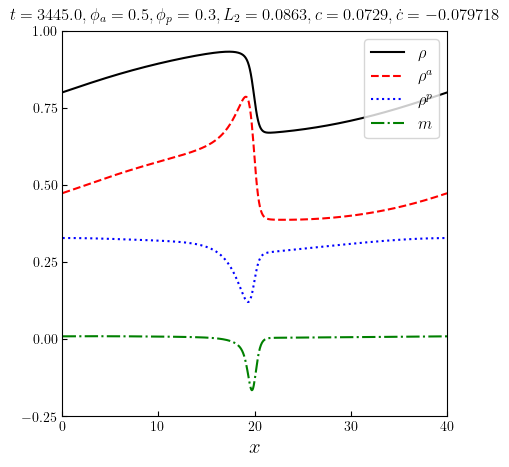

In [79]:
# get profile 
@unpack Nx, Δx, Lx = param
# Dispaly Profile
using PyPlot
PyPlot.close("all")
        rc("text", usetex=true)
        fig, ax = subplots(1,1,figsize=(5,5))
        @unpack Δx, Lx = param
        ax.plot(Δx:Δx:Lx, f[:,2]+f[:,1]+f[:,3]; 
        color = "black", linestyle = "-", label = L"\rho")
        ax.plot(Δx:Δx:Lx, f[:,1]+f[:,2]; 
        color = "red", linestyle = "--", label = L"\rho^a")
        ax.plot(Δx:Δx:Lx, f[:,3]; 
        color = "blue", linestyle = ":",label = L"\rho^p")
        ax.plot(Δx:Δx:Lx, f[:,2]-f[:,1]; 
        color = "green", linestyle = "-.", label = L"m")

        d2(x) = round(x; digits = 2)
        d4(x) = round(x; digits = 4)
        d6(x) = round(x; digits = 6)
        normf, c1, dc = f_dot(param, f)
        latex_string = latexstring("\$ t = $(d2(t)), \\phi_a = $(param["ϕa"]), \\phi_p = $(param["ϕp"]), L_2 = $(d4(normf)), c = $(d4(c1)), {\\dot c} = $(d6(dc))\$")
        ax.set_title(latex_string, fontsize = 12)
        ax.get_xaxis().set_ticks(0:10.0:Lx)
        ax.get_yaxis().set_ticks(-0.25:0.25:1.0)
        # ax.set_xlabel(L"x", fontsize = 15)
        #ax.set_ylabel(L"m",fontsize = font, rotation = 90)
        ax.set_aspect((Lx/(1.25)))
        ax.axis([0,Lx,-0.25,1.0])
        ax.tick_params(direction = "in")
        ax.legend(loc= "upper right", fontsize = 12)
        ax.set_xlabel(L"x", fontsize = 15)
display(fig)

In [ ]:
I = 4
for i in 1:I
        f, param = double_sol(param,f)
        c = u[end]

        u0 = get_u(f,c)
        @unpack DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp = param
        ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp)
        #
        prob = NonlinearProblem(ff, u0, ps; abstol = max(Δx*1e-5,1e-8), reltol =  max(Δx*1e-5,1e-8) )
        sol  = solve(prob)
        #
        u0 = sol.u
        prob = NonlinearProblem(ff, u0, ps; abstol = 1e-8, reltol =  1e-8)
        sol  = solve(prob)
        #
        u0 = sol.u
        prob = NonlinearProblem(ff, u0, ps; abstol = 1e-10, reltol =  1e-10)
        sol  = solve(prob)
        #
        u = sol.u
        f = get_f(u)
        c = u[end]
        filename    = steady_save_name(param)
        data        = Dict("f" => f, "c" => c)
        safesave(filename,data)
        print(param["Δx"])
end

In [ ]:
#
    @unpack DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp = param
    ps = (DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp)
    u = sol.u
    F = zeros(3*Nx+1)
    ff(F,u,ps);
#
maximum(abs.(F)), sol.u[end], param["Δx"]

(2.5604518505417673e-15, 0.0344219517861316, 0.025)

In [ ]:
# lengthen
function lengthen_f(f,param, LLx, NNx)
    @unpack Nx, Lx, Δx = param
    ΔΔx = Lx/NNx
    function fx(x,k)
        i::Int64 = x÷Δx
        j = i+1
        if i == 0
            i = Nx
        end
        return ( (Δx*(i+1)- x)*f[i,k] + (x-Δx*i)*f[j,k] )/(Δx)
    end
    g = zeros(NNx,3)
    for i in 1:3
        g[:,i] = fx.(ΔΔx:ΔΔx:Lx,i)
    end

    Δx = LLx/NNx
    Lx = LLx
    Nx = NNx
    @pack! param = Nx, Lx, Δx

    return param, g
end

lengthen_f (generic function with 1 method)

In [ ]:
Nx = 800
Lx = 40.0
Δx = Lx/Nx
@pack! param = Nx, Lx, Δx

(800, 40.0, 0.05)

In [ ]:
u = sol.u
f = get_f(u)
sol = []
param, f = lengthen_f(f,param, 40.0, 850)
u = get_u(f,c)
u0 = u
@unpack DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp = param
ps = DT, v0, DR, Δx, Nx, Lx, ϕa, ϕp

(1.0, 7.5, 1.0, 0.047058823529411764, 850, 40.0, 0.5, 0.3)

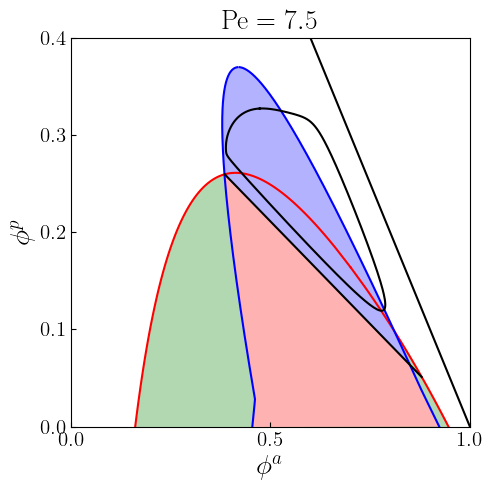

In [ ]:
using LaTeXStrings
function plot_phase(fig, ax, Pe; Lxs = [5,10,20])
    Pes = [Pe]
    axlims = [[0.0, 1.0, 0, 0.4]]
    axs = [ax]
    for (i,(ax, Pe, axlim)) in enumerate(zip(axs, Pes, axlims))
        # load binodal
            filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
            data = wload(filename)
            @unpack Pe, γs, ϕ1s, ϕ2s = data

        # plot binodal
            binod = ax.plot(gammas_converter_a(γs, ϕ1s), gammas_converter_p(γs, ϕ1s), color = "red", label = "Binodal")
            ax.plot(gammas_converter_a(γs, ϕ2s), gammas_converter_p(γs, ϕ2s), color = "red", label = "_Bindoal")
            #ax.plot(0.:0.1:1., 1.:-0.1:0., color = "black", label = "_Full")

            rc("text", usetex=true)
            ax.xaxis.set_tick_params(labelsize=15)
            ax.xaxis.tick_bottom()
            ax.yaxis.set_tick_params(labelsize=15)
            
            #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
            ax.set_xlabel(L"\phi^a",fontsize=20)
            ax.set_ylabel(L"\phi^p", fontsize=20)
            # ax.legend(loc = "upper right", fontsize=20)
            # ax.set_aspect(0.25*Δρ/ΔPe)
            title = latexstring("\$ \\mathrm{Pe} = $(Pe)\$")
            ax.set_title(title,fontsize=20)
            ax.tick_params(labelbottom = true, direction = "in")
        #
        # plot finite spin
                for Lx in Lxs
                    local ϕas_left, ϕas_right, ϕps
                    ϕas_left, ϕas_right, ϕps = return_spin_finite(;Pe = Pe, Δϕ = 0.001,Lx=Lx)
                    ax.plot(ϕas_left, ϕps, color = "blue", label = "_Spindoal", linestyle = "--", alpha = 0.5)
                    ax.plot(ϕas_right, ϕps, color = "blue", label = "_Spindoal", linestyle = "--", alpha = 0.5)
    
                    # find final find gamma
                    final_γ = 0.
                    final_ϕ1 = 0.
                    final_ϕ2 = 0.
                    for (γ, ϕ1, ϕ2) in zip(γs, ϕ1s, ϕ2s)
                        if (is_stable_value_finite(gamma_converter(γ, ϕ1)...; Pe = Pe, Lx=Lx)>0)|(is_stable_value_finite(gamma_converter(γ, ϕ2)...; Pe = Pe,Lx=Lx)>0)
                            final_γ = γ
                            final_ϕ1 = ϕ1
                            final_ϕ2 = ϕ2
                            break
                        end
                    end
                    # tie line
                    tie_line_x = -ϕps*final_γ/(final_γ-1).+1
                    xs = []
                    ys = []
                    for (x,y) in zip(tie_line_x,ϕps)
                        if (x+y ≤ final_ϕ2)&(x+y ≥ final_ϕ1)
                            push!(xs,x)
                            push!(ys,y)
                        end
                    end
                    ax.plot(xs,ys,color = "black", linestyle = "--", alpha = 0.5)
                end
        #
        # plot spinodal
            ϕas_left, ϕas_right, ϕps = return_spin(;Pe = Pe, Δϕ = 0.0001)
            ax.plot(ϕas_left, ϕps, color = "blue", label = "_Spindoal", linestyle = "-")
            ax.plot(ϕas_right, ϕps, color = "blue", label = "_Spindoal", linestyle = "-")
        #
        # phase shading
        if i ==2
            ax.fill_betweenx(ϕps,ϕas_left,ϕas_right , color = "red", alpha = 0.3, linewidth = 0) 
            max_ϕa = maximum(ϕas_left)
            max_ϕp = maximum(ϕps)
            ϕas_left, ϕas_right, ϕps, γ_grid, ϕ1_grid, ϕ2_grid = return_spin_from_grid(;max_ϕa = max_ϕa, Pe = Pe, γ_grid = γs, ϕ1_grid = ϕ1s, ϕ2_grid = ϕ2s, ϕp_grid = gammas_converter_p(γs, ϕ1s).+0.00001)
            ax.fill_betweenx(ϕps,gammas_converter_a(γ_grid, ϕ1_grid),ϕas_left,(gammas_converter_a(γ_grid, ϕ1_grid) .≤ ϕas_left), color = "green", alpha = 0.3, linewidth = 0)
        
            ax.fill_betweenx(ϕps,gammas_converter_a(γ_grid, ϕ1_grid),ϕas_right,(gammas_converter_a(γ_grid, ϕ1_grid) .≥ ϕas_right), color = "green", alpha = 0.3, linewidth = 0)
        
            #ax.plot(gammas_converter_a(γ_grid, ϕ2_grid), ϕps)
            #ax.plot(ϕas_right, ϕps)
            ϕas_left, ϕas_right, ϕps, γ_grid, ϕ1_grid, ϕ2_grid = return_spin_from_grid(;max_ϕa = max_ϕa, Pe = Pe, γ_grid = γs, ϕ1_grid = ϕ1s, ϕ2_grid = ϕ2s, ϕp_grid = gammas_converter_p(γs, ϕ2s).+0.00001)
            ax.fill_betweenx(ϕps,ϕas_right,gammas_converter_a(γ_grid,ϕ2_grid ),gammas_converter_a(γ_grid, ϕ2_grid) .≥ ϕas_right, color = "green", alpha = 0.3, linewidth = 0) 
        else
            # find final find gamma
            final_γ = 0.
            final_ϕ1 = 0.
            final_ϕ2 = 0.
            for (γ, ϕ1, ϕ2) in zip(γs, ϕ1s, ϕ2s)
                if (is_stable_value(gamma_converter(γ, ϕ1)...; Pe = Pe)>0)|(is_stable_value(gamma_converter(γ, ϕ2)...; Pe = Pe)>0)
                    final_γ = γ
                    final_ϕ1 = ϕ1
                    final_ϕ2 = ϕ2
                    break
                end
            end
            # shading
            tie_line_x = -ϕps*final_γ/(final_γ-1).+1
            ax.fill_betweenx(ϕps,max.(tie_line_x,ϕas_left),ϕas_right, max.(tie_line_x,ϕas_left) .≤ ϕas_right , color = "blue", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx(ϕps,ϕas_left,min.(tie_line_x,ϕas_right), ϕas_left .≤ min.(tie_line_x,ϕas_right) , color = "red", alpha = 0.3, linewidth = 0) 
            
            xs = []
            ys = []
            for (x,y) in zip(tie_line_x,ϕps)
                if (x+y ≤ final_ϕ2)&(x+y ≥ final_ϕ1)
                    push!(xs,x)
                    push!(ys,y)
                end
            end
            ax.plot(xs,ys,color = "black")

            max_ϕa = maximum(ϕas_left)
            ϕas_left, ϕas_right, ϕps, γ_grid, ϕ1_grid, ϕ2_grid = return_spin_from_grid(;max_ϕa = max_ϕa, Pe = Pe, γ_grid = γs, ϕ1_grid = ϕ1s, ϕ2_grid = ϕ2s, ϕp_grid = gammas_converter_p(γs, ϕ1s))
            ax.fill_betweenx(ϕps,gammas_converter_a(γ_grid, ϕ1_grid),ϕas_left,gammas_converter_a(γ_grid, ϕ1_grid) .≤ ϕas_left, color = "green", alpha = 0.3, linewidth = 0)
        
            ϕas_left, ϕas_right, ϕps, γ_grid, ϕ1_grid, ϕ2_grid = return_spin_from_grid(;max_ϕa = max_ϕa, Pe = Pe, γ_grid = γs, ϕ1_grid = ϕ1s, ϕ2_grid = ϕ2s, ϕp_grid = gammas_converter_p(γs, ϕ2s))
            ax.fill_betweenx(ϕps,ϕas_right,gammas_converter_a(γ_grid,ϕ2_grid ),gammas_converter_a(γ_grid, ϕ2_grid) .≥ ϕas_right, color = "green", alpha = 0.3, linewidth = 0) 
            
        end

    end
    fig.tight_layout()
    #axs[2].legend(loc = "upper right", fontsize=20)
    # for (i,(ax, params)) in enumerate(zip(axs, param_sets))
    #     ϕas = []
    #     ϕps = []
    #     for param in params
    #         local pde_ts, f_saves, f, t, ϕal, ϕag, ϕpl, ϕpg
    #         #load saves
    #         pde_ts, f_saves = load_compress_pde(param)
    #         f = f_saves[end]
    #         t = pde_ts[end]

    #         if t > 500
    #             rho = f[:,1] + f[:,2] + f[:,3]
    #             min_pt = argmax(rho)
    #             max_pt = argmin(rho)
    #             if min_pt<max_pt
    #                 global x,X
    #                 x = min_pt:5:max_pt
    #                 X = min_pt:(max_pt-min_pt):max_pt
    #             else
    #                 global x,X 
    #                 x = max_pt:5:min_pt
    #                 X = max_pt:(min_pt-max_pt):min_pt
    #             end


    #             ax.plot(f[X,1] + f[X,2], f[X,3], color = "black",linestyle = "-", label = "_gas phase", alpha = 0.5)

    #             ax.scatter(f[x,1] + f[x,2], f[x,3], color = "black", marker = ".", edgecolor = "black", s = 5.0, alpha = 1, label = "_gas phase")
                
    #             ϕal = maximum( f[x,1] + f[x,2])
    #             ϕag = minimum( f[x,1] + f[x,2])
    #             ϕpl = minimum( f[x,3] )
    #             ϕpg = maximum( f[x,3] )
            
    #             push!(ϕas, ϕal)
    #             push!(ϕas, ϕag)
    #             push!(ϕps, ϕpl)
    #             push!(ϕps, ϕpg)
    #         end
    #     end
    #     ax.scatter(ϕas, ϕps; color = "black", marker = "^", edgecolor = "black")
    # end
    ax.xaxis.set_ticks(0.:0.5:1.0)
    ax.yaxis.set_ticks(0.:0.1:0.4)
    ax.axis([0.0, 1.0, 0, 0.4])
end
using PyPlot
fig, ax = subplots(1,1,figsize=(5,5))
Pe= 7.5
plot_phase(fig, ax, Pe; Lxs = [])
ax.plot(f[:,1]+f[:,2],f[:,3]; color = "black")
ax.plot(0:0.01:1,1:-0.01:0; color = "black")
display(fig)
fig_name = "phase_plot"
     @unpack ϕa, ϕp, v0, Lx, Δx = param
     pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_stretch/$(fig_name)";
     mkpath(pathname)
     filename = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_stretch/$(fig_name)/Lx=$(Lx)_Δx=$(Δx).pdf";
     PyPlot.savefig(filename,dpi = 100, format = "pdf") #bbox_extra_artists=( ldg,)


3001×1 Matrix{Float64}:
 0.37651912746802907
 0.8008478358785058
 0.8012717880573214
 0.8016957560637259
 0.8021197346439294
 0.802543716799095
 0.8029676937342964
 0.8033916601759576
 0.8038156108485398
 0.804239540474533
 ⋮
 0.008076551822700923
 0.00808532611874127
 0.008094033911741794
 0.008102651807083083
 0.008111201362316717
 0.008119681969479625
 0.008128093022026411
 0.00813643391481661
 0.033824358358296905